### Bayesian analysis of battery discharge measurements

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import warnings

In [2]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [3]:
from scipy import spatial

In [4]:
# Ignore future warnings.
warnings.simplefilter(action='ignore', category=(FutureWarning, RuntimeWarning))

In [5]:
az.style.use('seaborn-v0_8-darkgrid')

#### Battery discharge measurements

In [6]:
# Excel file contains sheets, one for each discharge measurement.
file_name = 'measurements.xlsx'
# Sheet names:
discharges = [
    '21-11-25',  # first discharge measurement
    '05-12-25',
    '22-12-25',
    '05-01-26',
    '16-01-26',
]

In [7]:
# Dictionary of dataframes, one for each excel sheet.
dataset = {}
for i, name in enumerate(discharges):
    df = pd.read_excel(file_name, sheet_name=name)
    dataset[name] = df

In [8]:
# Measurements from the first discharge test.
data = dataset[discharges[0]].copy()
data

,Battery,X/cm,Y/cm,Zi,Rij,Ui(0),Ui(6),Ui(12),Ui(18),Ui(24),...,Ti(36),Ti(42),Ti(48),Ti(54),Ti(60),Ti(66),Ti(72),Ti(78),Ti(84),Ti(90)
0,B1,23,77,1.13,78,2.32,2.03,2.03,2.03,2.02,...,25.1,25.1,25.1,25.1,25.1,25.5,25.5,25.5,25.8,26.6
1,B2,45,77,1.04,90,2.31,2.03,2.03,2.03,2.02,...,25.1,25.1,25.1,25.1,25.1,25.5,25.5,25.5,25.8,26.4
2,B3,66,77,1.14,222,2.30,2.02,2.02,2.02,2.01,...,25.1,25.1,25.1,25.1,25.1,25.5,25.5,25.5,25.8,26.4
3,B4,87,77,0.92,109,2.30,2.03,2.03,2.03,2.03,...,25.1,25.1,25.1,25.1,25.1,25.5,25.5,25.5,25.8,26.4
4,B5,98,63,0.93,141,2.30,2.02,2.02,2.02,2.02,...,25.1,25.1,25.1,25.1,25.1,25.5,25.5,25.5,25.8,26.4
5,B6,118,63,0.92,49,2.30,2.03,2.03,2.03,2.03,...,25.4,25.4,25.4,25.4,25.4,25.1,25.1,25.1,25.7,26.4
6,B7,139,63,0.87,61,2.30,2.03,2.03,2.02,2.02,...,25.4,25.4,25.4,25.4,25.4,25.1,25.1,25.1,25.7,25.8
7,B8,162,63,0.97,48,2.50,2.03,2.03,2.03,2.02,...,25.4,25.4,25.4,25.4,25.4,25.1,25.1,25.1,25.7,25.8
8,B9,174,77,0.71,59,2.31,2.04,2.04,2.04,2.03,...,25.4,25.4,25.4,25.4,25.4,26.8,26.8,26.8,27.5,27.7
9,B10,195,77,75.40,58,1.83,0.12,0.09,0.09,0.08,...,26.9,26.9,26.9,27.1,28.2,29.4,29.4,29.8,30.4,31.0


#### Battery geometry and distance metric

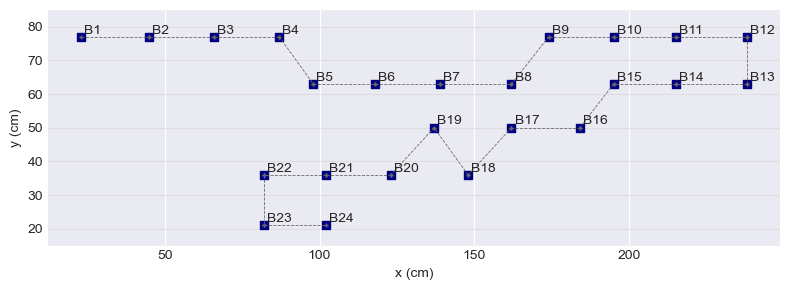

In [9]:
# Coordinates of the battery arrangment (center points).
x_coords = data['X/cm'].values
y_coords = data['Y/cm'].values

fig, ax = plt.subplots(figsize=(8,3))
ax.grid(which='major', axis='y', color='lightgrey', alpha=0.5)
ax.scatter(x_coords, y_coords, marker='s', s=40, c='navy')
for i in range(len(x_coords)-1):
    ax.plot([x_coords[i], x_coords[i+1]], [y_coords[i], y_coords[i+1]],
            ls='--', lw=0.6, marker='+', markersize=3, c='dimgrey')
eps = 1  # label offset (data coordinates)
for i, itext in enumerate(data['Battery'].values):
    ax.text(x_coords[i]+eps, y_coords[i]+eps, itext, fontsize=10, zorder=2)
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_ylim(15, 85)
fig.tight_layout()
plt.savefig('geometry.png', dpi=600)
plt.show()

In [10]:
# Investigating correlations between cells arising
# from geometry, connections and graph structure.
# Battery centers (x,y) coordinates (meters).
coords = [(float(x)/100, float(y)/100) for x, y in zip(x_coords, y_coords)]
# Euclidean distances between battery center points.
d_mat = spatial.distance.cdist(coords, coords, metric='euclidean')
d_mat2 = np.power(d_mat, 2)  # squared distance
# Normalized battery connection resistances.
rij = data['Rij'].values / data['Rij'].values.sum()
# Connectivity graph.
r_mat = np.zeros(shape=(len(rij), len(rij)), dtype=float)
for i in range(len(rij)-1):
    for j in range(i+1, len(rij)):
        r_mat[i, j] = sum(rij[i:j])
        r_mat[j, i] = r_mat[i, j]
# Distance metric (example).
dm = r_mat + d_mat2

#### Gaussian process Bayesian regression

In [11]:
pct_error = 10.
n = len(data['Battery'].values)
noise = np.random.normal(loc=0, scale=pct_error/100, size=n)
data['deltaT'] = data['Ti(84)'] - data['Ti(0)'] + noise
delta_t = data['deltaT'].values
zi_data = data['Zi'].values
weights = (pct_error/100) * zi_data
index_values = data.index

In [12]:
c = {
    'id': data['Battery'].values
}
# Bayesian regression with Gaussian processes.
with pm.Model(coords=c) as mvt:
    # Data containers.
    x = pm.Data('x', delta_t)
    y = pm.Data('y', zi_data)
    idx = pm.Data('idx', index_values)
    # Covariance matrix.
    eta = pm.Exponential('eta', lam=2)
    rho = pm.Exponential('rho', lam=0.5)
    Kij = eta * np.exp(-rho * dm) + np.diag([0.01]*n)
    # Multivariate prior.
    gamma = pm.MvStudentT('gamma', nu=4, mu=np.zeros(n), cov=Kij, dims='id')
    # Additional priors.
    alpha = pm.Normal('alpha', mu=0, sigma=2)
    sigma = pm.HalfCauchy('sigma', beta=2)
    # Linear model.
    mu = alpha + x * gamma[idx]
    # Likelihood.
    obs = pm.StudentT('obs', nu=4, mu=mu, sigma=sigma,
                      observed=np.log(y), dims='id')  # natural log scale
    # MCMC sampling.
    idata = pm.sample(draws=6000, tune=2000,
                      target_accept=0.99, max_treedepth=15,
                      idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, rho, gamma, alpha, sigma]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 189 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
measurement_error = False
if measurement_error:
    # Bayesian regression with Gaussian processes
    # that incorporates measurement errors (uncertainty).
    with pm.Model(coords=c) as mvt_err:
        # Data containers.
        x = pm.Data('x', delta_t)
        y = pm.Data('y', zi_data)
        w = pm.Data('w', weights)
        idx = pm.Data('idx', index_values)
        # Covariance matrix.
        eta = pm.Exponential('eta', lam=2)
        rho = pm.Exponential('rho', lam=0.5)
        Kij = eta * np.exp(-rho * dm) + np.diag([0.01]*n)
        # Multivariate prior.
        gamma = pm.MvStudentT('gamma', nu=4, mu=np.zeros(n), cov=Kij, dims='id')
        # Additional priors.
        alpha = pm.Normal('alpha', mu=0, sigma=2)
        sigma = pm.HalfCauchy('sigma', beta=2)
        # Linear model.
        mu = alpha + x * gamma[idx]
        # Likelihood.
        est = pm.Normal('est', mu=mu, sigma=sigma)
        obs = pm.Normal('obs', mu=est, sigma=w, observed=np.log(y), dims='id')
        # MCMC sampling.
        idata_err = pm.sample(draws=6000, tune=2000,
                              target_accept=0.99, max_treedepth=15,
                              idata_kwargs={'log_likelihood': True})

In [14]:
if measurement_error:
    # Bayesian model comparison.
    traces_dict = {
        'GP': idata,  # GP regression w/o measurement errors
        'GPE': idata_err,  # GP regression w/ measur. errors
    }
    # Pareto-smoothed importance sampling leave-one-out cross-validation (LOOCV).
    model_comparison = az.compare(traces_dict, ic='loo', method='stacking')
    # Plot comparison using Arviz.
    fig, ax = plt.subplots(figsize=(5, 2.6))
    az.plot_compare(model_comparison, plot_ic_diff=True, title=False, 
                    textsize=10, plot_kwargs={'color_ic': 'navy'}, ax=ax)
    fig.tight_layout()
    plt.show()
    # Re-assign trace for further processing.
    idata = idata_err

In [15]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

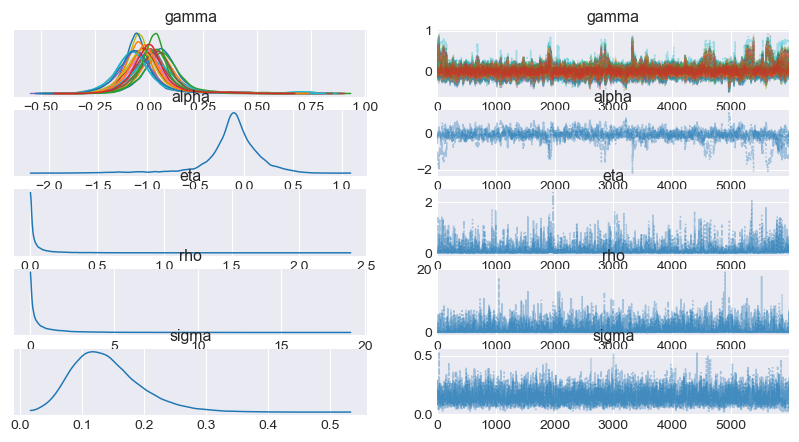

In [16]:
az.plot_trace(idata, figsize=(10, 5), combined=True);

In [17]:
# Parameters are in natural log scale.
az.summary(idata, kind='stats')

,mean,sd,hdi_3%,hdi_97%
gamma[B1],0.066,0.110,-0.142,0.269
gamma[B2],0.051,0.117,-0.181,0.253
gamma[B3],0.069,0.122,-0.159,0.293
gamma[B4],0.018,0.113,-0.209,0.211
gamma[B5],0.017,0.114,-0.206,0.218
gamma[B6],0.012,0.119,-0.226,0.217
gamma[B7],-0.002,0.113,-0.220,0.196
gamma[B8],0.019,0.115,-0.206,0.218
gamma[B9],-0.037,0.081,-0.193,0.111
gamma[B10],0.041,0.164,-0.239,0.286


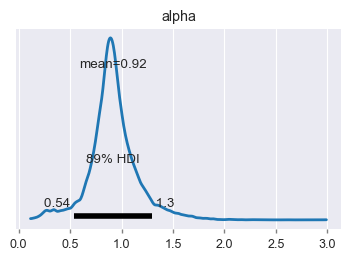

In [18]:
az.plot_posterior(idata, var_names=['alpha'], 
                  transform=np.exp,  # transform back to the original scale
                  hdi_prob=0.89, figsize=(4.2, 2.6), lw=2, textsize=9)
plt.show()

In [19]:
with mvt:
    # Posterior predictive samples for model checking.
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [obs]


Output()

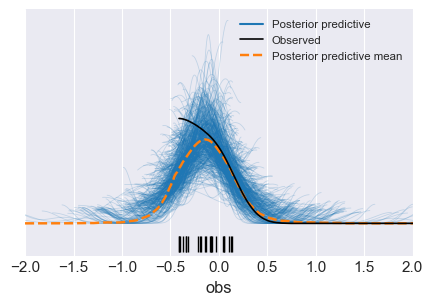

In [20]:
# Posterior predictive vs observed likelihood.
fig, ax = plt.subplots(figsize=(5, 3.2))
az.plot_ppc(idata, observed=True, observed_rug=True, 
            num_pp_samples=500, textsize=11, ax=ax)
ax.set_xlim(-2, 2)
plt.show()

In [21]:
eta = idata.posterior['eta'].mean(dim='chain').values
rho = idata.posterior['rho'].mean(dim='chain').values
Kij_post = eta.mean() * np.exp(-rho.mean() * dm) + np.diag([0.01]*n)
# Convert covariances to correlation matrix.
sigma_post = np.sqrt(np.diag(Kij_post))
sigma_post_inv = np.diag(np.power(sigma_post, -1))  # invert
Rho = sigma_post_inv @ Kij_post @ sigma_post_inv
Rho = pd.DataFrame(Rho, index=data['Battery'].values,
                   columns=data['Battery'].values)

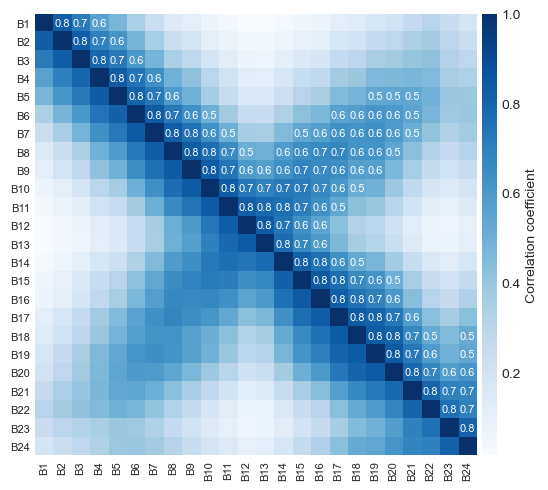

In [22]:
# Mean correlations.
label_threshold = 0.5
fig, ax = plt.subplots(figsize=(6, 5))
ax.grid(False)
im = ax.imshow(Rho, cmap='Blues')
cb = plt.colorbar(im, ax=ax, pad=0.01, aspect=30)
cb.ax.set_ylabel('Correlation coefficient')
ax.set_xticks(range(n), data['Battery'].values, rotation=90, fontsize=8)
ax.set_yticks(range(n), data['Battery'].values, fontsize=8)
for i in range(n):
    for j in range(i+1, n):
        if Rho.values[i, j] > label_threshold:
            text = ax.text(j, i, f'{Rho.values[i, j]:.1f}',
                           ha='center', va='center',
                           color='white', fontsize=8)
fig.tight_layout(pad=1.05)
plt.savefig('correlations.png', dpi=600)
plt.show()

In [23]:
alpha = idata.posterior['alpha'].mean(dim='chain')
gamma = idata.posterior['gamma'].mean(dim='chain')
# Retrodict impedances.
zi_retrodict = np.exp(alpha + delta_t * gamma[index_values])

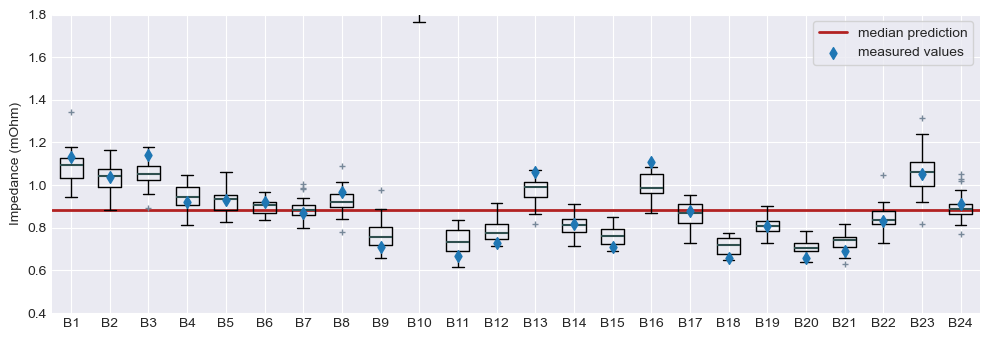

In [24]:
# Retrodictions.
labels = data['Battery'].values
zi_median = np.median(zi_retrodict, axis=0)
fig, ax = plt.subplots(figsize=(10, 3.5))
ax.axhline(np.median(zi_median), linestyle='-', linewidth=2, 
           color='firebrick', label='median prediction')
ax.boxplot(zi_retrodict, positions=range(len(labels)),
           widths=0.6, showmeans=False, showfliers=True,
           flierprops={'marker': '+', 'markersize': 5,
                       'markeredgecolor': 'lightslategrey'},
           medianprops={'color': 'darkslategrey', 'linewidth': 1.5})
ax.scatter(range(len(labels)), data['Zi'].values, marker='d',
           label='measured values', zorder=99)
ax.legend(loc='upper right', frameon=True, fancybox=True, framealpha=0.8)
ax.set_xticklabels(labels)
ax.set_ylabel('Impedance (mOhm)')
ax.set_ylim(0.4, 1.8)
fig.tight_layout()
plt.savefig('retrodictions.png', dpi=600)
plt.show()

#### Predictions on the test measurements (second cycle)

In [25]:
# Test set (second measurement).
test = dataset[discharges[1]].copy()

In [26]:
test['delta_t'] = test['Ti(84)'] - test['Ti(0)'] + noise
dt_test = test['delta_t'].values
y_test = test['Zi'].values
w_test = (pct_error/100) * y_test

In [27]:
with mvt:
    pm.set_data({'x': dt_test})
    pm.set_data({'y': y_test})
    y_predict = pm.sample_posterior_predictive(idata, predictions=True)

Sampling: [obs]


Output()

In [28]:
# Predicted Zi values from the test set.
zi_predict = np.exp(y_predict.predictions['obs'].median(dim='chain').values)
# Median predicted impedance value.
y_pred = np.exp(y_predict.predictions['obs'].median(dim=['chain', 'draw']).values)

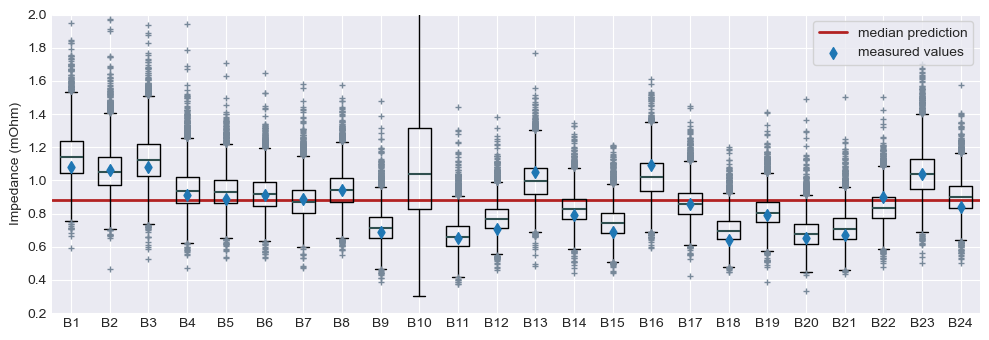

In [29]:
# Predictions.
fig, ax = plt.subplots(figsize=(10, 3.5))
ax.axhline(np.median(y_pred), linestyle='-', linewidth=2, 
           color='firebrick', label='median prediction')
ax.boxplot(zi_predict, positions=range(len(labels)),
           widths=0.6, showmeans=False, showfliers=True,
           flierprops={'marker': '+', 'markersize': 4,
                       'markeredgecolor': 'lightslategrey'},
           medianprops={'color': 'darkslategrey', 'linewidth': 1.5})
ax.scatter(range(len(labels)), y_test, marker='d',
           label='measured values', zorder=99)
ax.legend(loc='upper right', frameon=True, fancybox=True, framealpha=0.8)
ax.set_xticklabels(labels)
ax.set_ylabel('Impedance (mOhm)')
ax.set_ylim(0.2, 2)
fig.tight_layout()
plt.savefig('predictions.png', dpi=600)
plt.show()

In [30]:
# RMSE and MAPE errors.
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse:.2f} (mOhm)')
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape*100:.2f} %')

RMSE: 3.15 (mOhm)
MAPE: 7.53 %


### Battery discharge curves Q(V)

In [31]:
qdata = dataset[discharges[1]].copy()
# Removing the B10 cell from the data (outlier).
qdata.drop(index=9, inplace=True)  # B10
qdata.reset_index(drop=True, inplace=True)

In [32]:
capacity = pd.read_excel(file_name, sheet_name='Kapacitet')
capacity.dropna(axis='columns', inplace=True)  # remove empty columns

In [33]:
c_bat = capacity.iloc[2, 2:].values  # 05-12-25

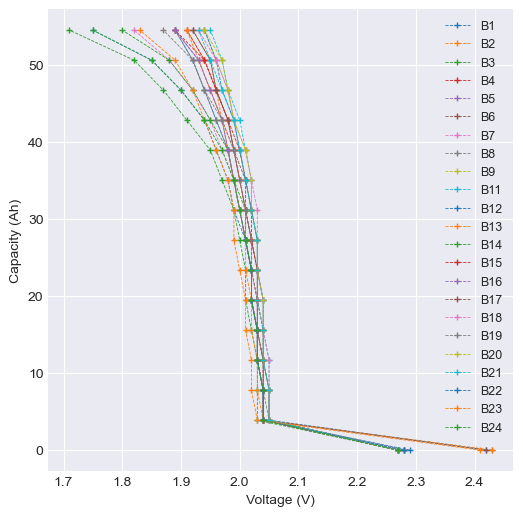

In [34]:
stride = 5
fig, ax = plt.subplots(figsize=(6, 6))
for i in qdata.index:
    bat = qdata['Battery'].iloc[i]
    ax.plot(qdata.iloc[i, stride:stride+len(c_bat)].values, c_bat,
            ls='--', lw=0.6, marker='+', ms=4, label=f'{bat}')
ax.legend(fontsize=9)
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Capacity (Ah)')
plt.show()

In [35]:
THR = 10.  # threshold
ib = np.argwhere(c_bat < THR)[-1]
dqdv = np.empty(len(qdata.index))
for i in qdata.index:
    vb = qdata.iloc[i, stride:stride+len(c_bat)]
    dqdv[i] = abs(c_bat[-1] - c_bat[ib]) / abs(vb[ib] - vb[-1])
qdata['dqdv'] = dqdv

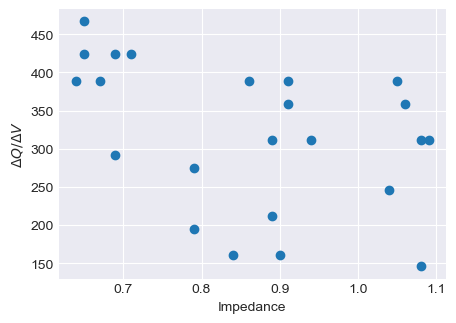

In [36]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.scatter(qdata['Zi'].values, qdata['dqdv'].values)
ax.set_xlabel('Impedance')
ax.set_ylabel(r'$\Delta Q / \Delta V$')
plt.show()

In [37]:
# Standardize.
scale = StandardScaler()
dqdv = scale.fit_transform(dqdv.reshape(-1, 1)).flatten()

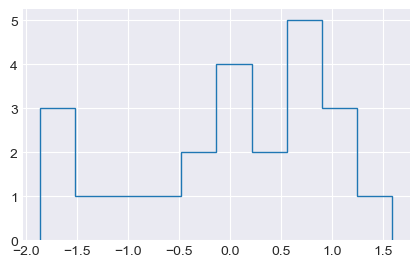

In [38]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(dqdv, histtype='step')
plt.show()

#### Repeated discharge measurements

In [39]:
# Select a battery to display its repeated discharges:
bat_id = 'B3'  # EDIT HERE
voltage = {}
for name in discharges:
    idx = np.argwhere(dataset[name]['Battery'].values == bat_id)[0][0]
    cols = [c for c in dataset[name].columns if 'Ui' in c]
    voltage[name] = dataset[name].iloc[idx][cols]

In [40]:
capacity = pd.read_excel(file_name, sheet_name='Kapacitet')
charge = {}
for i, name in enumerate(discharges):
    charge[name] = capacity.iloc[i][2:]

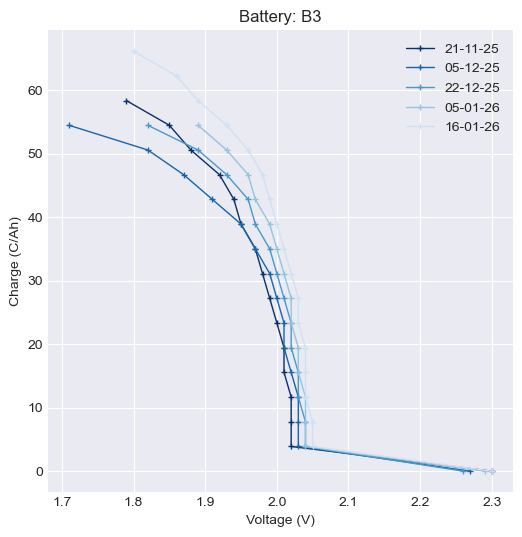

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Battery: '+bat_id)
for i, name in enumerate(discharges):
    end = len(voltage[name])
    colors = plt.cm.Blues_r(np.linspace(0, 0.8, len(discharges)))
    ax.plot(voltage[name], charge[name][:end], c=colors[i],
            ls='-', lw=1, marker='+', ms=4, label=name)
ax.legend(loc='upper right')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Charge (C/Ah)')
plt.show()

### Multi-level models for repeated trials

In [42]:
# Dictionary of dataframes, one for each excel sheet.
dataset = {}
for i, name in enumerate(discharges):
    df = pd.read_excel(file_name, sheet_name=name)
    # Add column with a discharge cycle index value.
    df['Discharge'] = i
    dataset[name] = df
# Create a single DataFrame with all measurements.
measurements = pd.concat(
    [dataset[discharges[i]] for i in range(len(discharges))],
    axis=0, ignore_index=True
)
# Extract only relevant columns.
measurements = measurements[['Battery', 'Zi', 'Discharge']]
cell_names = pd.Categorical(measurements['Battery'].values)

#### Clustering on battery cells

In [43]:
coords_cells = {
    'samples': measurements.index,
    'cells': cell_names.categories,
}
# Partial pooling model.
with pm.Model(coords=coords_cells) as multicell:
    # Data containers.
    zi = pm.Data('zi', np.log(measurements['Zi']), dims='samples')  # log scale
    idc = pm.Data('idc', cell_names.codes, dims='samples')
    # Hyperpriors.
    mu_c = pm.StudentT('mu_c', nu=2, mu=0, sigma=10)
    sigma_c = pm.HalfCauchy('sigma_c', beta=10)
    # Priors.
    mu = pm.StudentT('mu', nu=2, mu=mu_c, sigma=sigma_c, dims='cells')
    sigma = pm.HalfCauchy('sigma', beta=10)
    nu = pm.Exponential('nu', lam=0.5)
    # Likelihood.
    obs = pm.StudentT('likelihood', nu=nu, mu=mu[idc], sigma=sigma,
                      observed=zi, dims='samples')
    # MCMC sampling.
    idata_cell = pm.sample(draws=6000, tune=2000,
                           target_accept=0.99, max_treedepth=15,
                           idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_c, sigma_c, mu, sigma, nu]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 76 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [44]:
# Parameters are in natural log scale.
az.summary(idata_cell, kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu_c,-0.159,0.049,-0.251,-0.068
mu[B1],0.085,0.011,0.063,0.106
mu[B10],3.071,0.397,2.741,4.027
mu[B11],-0.421,0.013,-0.445,-0.396
mu[B12],-0.335,0.013,-0.358,-0.311
mu[B13],0.043,0.009,0.026,0.061
mu[B14],-0.242,0.009,-0.259,-0.223
mu[B15],-0.367,0.008,-0.382,-0.351
mu[B16],0.075,0.010,0.058,0.095
mu[B17],-0.156,0.009,-0.172,-0.138


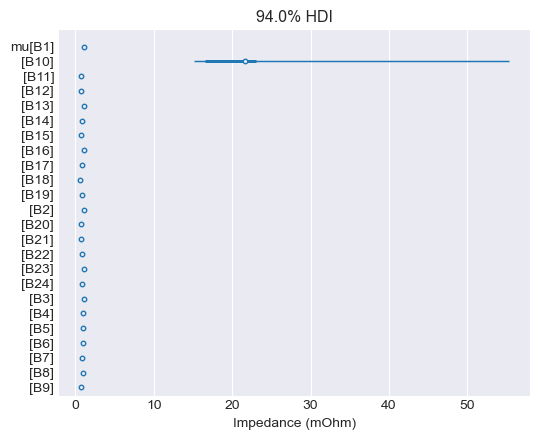

In [45]:
fig, ax = plt.subplots(figsize=(5.5, 4.5))
az.plot_forest(idata_cell, var_names=['mu'],
               transform=np.exp,  # transform back to the original scale
               combined=True, textsize=10, ax=ax)
ax.set_xlabel('Impedance (mOhm)')
fig.tight_layout()
plt.show()

In [46]:
coords_cells = {
    'samples': measurements.index,
    'cells': cell_names.categories,
}
# No pooling model.
with pm.Model(coords=coords_cells) as multicell2:
    # Data containers.
    zi = pm.Data('zi', np.log(measurements['Zi']), dims='samples')  # log scale
    idc = pm.Data('idc', cell_names.codes, dims='samples')
    # Priors.
    mu = pm.StudentT('mu', nu=2, mu=0, sigma=10, dims='cells')
    sigma = pm.HalfCauchy('sigma', beta=10)
    nu = pm.Exponential('nu', lam=0.5)
    # Likelihood.
    obs = pm.StudentT('likelihood', nu=nu, mu=mu[idc], sigma=sigma,
                      observed=zi, dims='samples')
    # MCMC sampling.
    idata_cell2 = pm.sample(draws=6000, tune=2000,
                            target_accept=0.99, max_treedepth=15,
                            idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 70 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [47]:
# Parameters are in natural log scale.
az.summary(idata_cell2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu[B1],0.086,0.011,0.065,0.107
mu[B10],3.119,0.380,2.756,4.017
mu[B11],-0.423,0.013,-0.445,-0.397
mu[B12],-0.336,0.013,-0.359,-0.312
mu[B13],0.043,0.009,0.026,0.060
mu[B14],-0.242,0.009,-0.259,-0.224
mu[B15],-0.368,0.008,-0.383,-0.351
mu[B16],0.076,0.010,0.059,0.095
mu[B17],-0.156,0.009,-0.172,-0.138
mu[B18],-0.446,0.009,-0.462,-0.428


In [48]:
# Battery cell B10 (transformed back to the original scale).
mu10_pp = np.exp(idata_cell['posterior']['mu'].mean(dim='chain')[:,1])
mu10_np = np.exp(idata_cell2['posterior']['mu'].mean(dim='chain')[:,1])

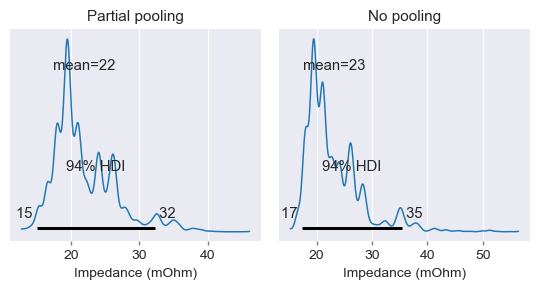

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(5.5, 3))
az.plot_posterior(mu10_pp, textsize=10, ax=ax[0])
ax[0].set_title('Partial pooling', fontsize=11)
ax[0].set_xlabel('Impedance (mOhm)', fontsize=10)
az.plot_posterior(mu10_np, textsize=10, ax=ax[1])
ax[1].set_title('No pooling', fontsize=11)
ax[1].set_xlabel('Impedance (mOhm)', fontsize=10)
fig.tight_layout()
plt.show()

In [50]:
coords_cells = {
    'samples': measurements.index,
}
# Complete pooling model.
with pm.Model(coords=coords_cells) as multicell3:
    # Data containers.
    zi = pm.Data('zi', np.log(measurements['Zi']), dims='samples')  # log scale
    # Priors.
    mu = pm.StudentT('mu', nu=2, mu=0, sigma=10)
    sigma = pm.HalfCauchy('sigma', beta=10)
    nu = pm.Exponential('nu', lam=0.5)
    # Likelihood.
    obs = pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma,
                      observed=zi, dims='samples')
    # MCMC sampling.
    idata_cell3 = pm.sample(4000, target_accept=0.99, max_treedepth=15,
                            idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 7 seconds.


In [51]:
# Parameters are in natural log scale.
az.summary(idata_cell3, kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu,-0.153,0.021,-0.193,-0.113
sigma,0.167,0.017,0.135,0.200
nu,1.980,0.362,1.344,2.668


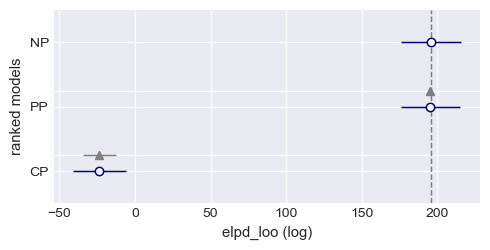

In [52]:
# Bayesian model comparison.
traces_dict_cell = {
    'PP': idata_cell,   # partial pooling
    'NP': idata_cell2,  # no pooling
    'CP': idata_cell3,  # complete pooling
}
# Pareto-smoothed importance sampling leave-one-out cross-validation (LOOCV).
model_comparison = az.compare(traces_dict_cell, ic='loo', method='stacking')

fig, ax = plt.subplots(figsize=(5, 2.6))
az.plot_compare(model_comparison, plot_ic_diff=True, title=False, 
                textsize=10, plot_kwargs={'color_ic': 'navy'}, ax=ax)
fig.tight_layout()
plt.show()

In [53]:
az.compare(traces_dict_cell, ic='loo', method='stacking').round(3)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
NP,0,195.688,61.050,0.000,1.0,19.665,0.000,False,log
PP,1,195.353,62.084,0.334,0.0,19.710,0.396,False,log
CP,2,-23.559,4.017,219.247,0.0,17.309,10.911,False,log


#### Clustering on measurement cycles

In [54]:
coords_cycles = {
    'samples': measurements.index,
    'cycles': range(len(discharges)),
}
# Partial pooling model.
with pm.Model(coords=coords_cycles) as multicycle:
    # Data containers.
    zi = pm.Data('zi', np.log(measurements['Zi']), dims='samples')  # log scale
    idc = pm.Data('idc', measurements['Discharge'], dims='samples')
    # Hyperpriors.
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfCauchy('sigma_c', beta=10)
    sigma_s = pm.HalfCauchy('sigma_s', beta=10)
    # Priors.
    mu = pm.Normal('mu', mu=mu_c, sigma=sigma_c, dims='cycles')
    sigma = pm.HalfCauchy('sigma', beta=sigma_s, dims='cycles')
    nu = pm.Exponential('nu', lam=0.5)
    # Likelihood.
    obs = pm.StudentT('likelihood', nu=nu, mu=mu[idc], sigma=sigma[idc],
                      observed=zi, dims='samples')
    # MCMC sampling.
    idata_cycle = pm.sample(draws=4000, tune=2000,
                            target_accept=0.99, max_treedepth=15,
                            idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_c, sigma_c, sigma_s, mu, sigma, nu]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 131 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.


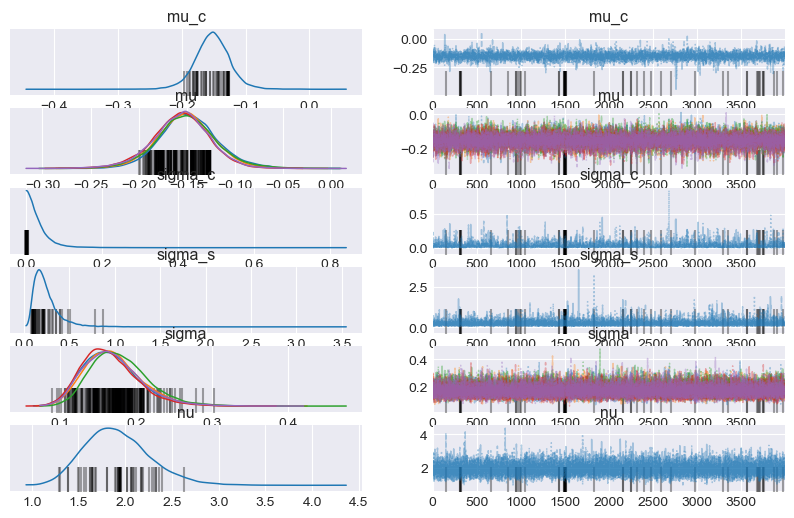

In [55]:
az.plot_trace(idata_cycle, figsize=(10, 6), combined=True);

In [56]:
# Parameters are in natural log scale.
az.summary(idata_cycle, kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu_c,-0.152,0.029,-0.206,-0.100
mu[0],-0.147,0.030,-0.205,-0.089
mu[1],-0.151,0.030,-0.210,-0.095
mu[2],-0.150,0.032,-0.215,-0.092
mu[3],-0.157,0.030,-0.215,-0.101
mu[4],-0.156,0.031,-0.214,-0.099
sigma_c,0.032,0.035,0.001,0.085
sigma_s,0.249,0.160,0.054,0.512
sigma[0],0.168,0.038,0.101,0.241
sigma[1],0.170,0.038,0.103,0.242


In [57]:
# Estimate the impedance trend line from the model cycles posterior data.
# Parameters are transformed back to the original scale.
trend_data = np.exp(idata_cycle['posterior']['mu'].mean(dim=('chain', 'draw')).values)
support = np.arange(len(discharges)).reshape(-1, 1)
lm = LinearRegression()
lm.fit(support, trend_data.reshape(-1, 1))
y_trend = lm.predict(support)

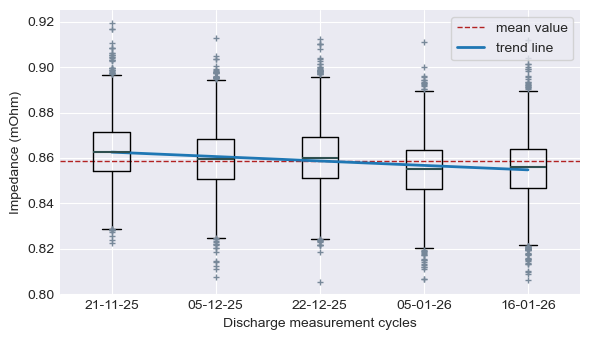

In [58]:
# Parameters are transformed back to the original scale.
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.axhline(np.exp(idata_cycle['posterior']['mu_c'].mean(dim=('chain', 'draw'))),
           linestyle='--', linewidth=1, color='firebrick', label='mean value')
ax.boxplot(np.exp(idata_cycle['posterior']['mu'].mean(dim='chain')),
           positions=range(len(discharges)),
           widths=0.35, showmeans=False, showfliers=True,
           flierprops={'marker': '+', 'markersize': 5,
                       'markeredgecolor': 'lightslategrey'},
           medianprops={'color': 'darkslategrey', 'linewidth': 1.5})
ax.plot(support, y_trend, ls='-', lw=2, label='trend line')
ax.legend(loc='upper right', frameon=True, fancybox=True, framealpha=0.8)
ax.set_xticklabels(discharges)
ax.set_xlabel('Discharge measurement cycles')
ax.set_ylabel('Impedance (mOhm)')
fig.tight_layout()
plt.show()

In [59]:
# Partial pooling with a unique variance.
with pm.Model(coords=coords_cycles) as multicycle2:
    # Data containers.
    zi = pm.Data('zi', np.log(measurements['Zi']), dims='samples')  # log space
    idc = pm.Data('idc', measurements['Discharge'], dims='samples')
    # Hyperpriors.
    mu_c = pm.Normal('mu_c', mu=0, sigma=10)
    sigma_c = pm.HalfCauchy('sigma_c', beta=10)
    # Priors.
    mu = pm.Normal('mu', mu=mu_c, sigma=sigma_c, dims='cycles')
    sigma = pm.HalfCauchy('sigma', beta=10)
    nu = pm.Exponential('nu', lam=0.5)
    # Likelihood.
    obs = pm.StudentT('likelihood', nu=nu, mu=mu[idc], sigma=sigma,
                      observed=zi, dims='samples')
    # MCMC sampling.
    idata_cycle2 = pm.sample(4000, target_accept=0.99, max_treedepth=15,
                             idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_c, sigma_c, mu, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 55 seconds.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.


In [60]:
# Parameters are in natural log scale.
az.summary(idata_cycle2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu_c,-0.153,0.029,-0.207,-0.100
mu[0],-0.149,0.030,-0.207,-0.090
mu[1],-0.152,0.031,-0.213,-0.096
mu[2],-0.151,0.031,-0.210,-0.089
mu[3],-0.158,0.030,-0.216,-0.100
mu[4],-0.157,0.030,-0.216,-0.101
sigma_c,0.032,0.035,0.001,0.082
sigma,0.167,0.017,0.135,0.200
nu,1.979,0.360,1.338,2.670


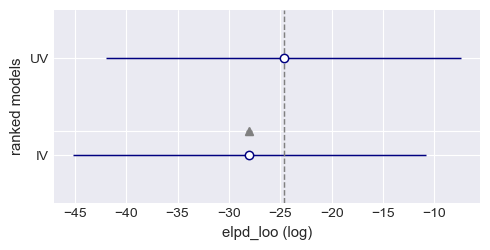

In [61]:
# Bayesian model comparison.
traces_dict_cycle = {
    'IV': idata_cycle,   # partial pooling (individual variance)
    'UV': idata_cycle2,  # partial pooling (unique variance)
}
# Pareto-smoothed importance sampling leave-one-out cross-validation (LOOCV).
model_comparison = az.compare(traces_dict_cycle, ic='loo', method='stacking')

fig, ax = plt.subplots(figsize=(5, 2.6))
az.plot_compare(model_comparison, plot_ic_diff=True, title=False, 
                textsize=10, plot_kwargs={'color_ic': 'navy'}, ax=ax)
fig.tight_layout()
plt.show()

### Clustering on both cells and cycles

In [76]:
coords = {
    'samples': measurements.index,
    'cells': cell_names.categories,
    'cycles': range(len(discharges)),
}
# Clustering on cells and cycles at the same time.
with pm.Model(coords=coords) as multi:
    # Data containers.
    zi = pm.Data('zi', np.log(measurements['Zi']), dims='samples')  # log scale
    idc = pm.Data('idc', cell_names.codes, dims='samples')  # cells
    ids = pm.Data('ids', measurements['Discharge'], dims='samples')  # cycles
    # Hyperpriors.
    sigma_c = pm.HalfCauchy('sigma_cells', beta=10)
    sigma_s = pm.HalfCauchy('sigma_cycles', beta=10)
    # Priors.
    mu_base = pm.Normal('mu_base', mu=0, sigma=10)
    mu_cells = pm.StudentT('mu_cell', nu=2, mu=0, sigma=sigma_c, dims='cells')
    mu_cycles = pm.StudentT('mu_cycle', nu=2, mu=0, sigma=sigma_s, dims='cycles')
    sigma = pm.HalfCauchy('sigma', beta=10)
    nu = pm.Exponential('nu', lam=0.5)
    # Link.
    mu = mu_base + mu_cells[idc] + mu_cycles[ids]
    # Likelihood.
    obs = pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma,
                      observed=zi, dims='samples')
    # MCMC sampling.
    idata_multi = pm.sample(draws=4000, tune=2000,
                            target_accept=0.99, max_treedepth=15,
                            idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_cells, sigma_cycles, mu_base, mu_cell, mu_cycle, sigma, nu]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 494 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [77]:
# Parameters are in natural log scale.
az.summary(idata_multi, kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu_base,-0.162,0.049,-0.257,-0.070
mu_cell[B1],0.250,0.049,0.157,0.340
mu_cell[B10],3.187,0.358,2.850,4.196
mu_cell[B11],-0.270,0.048,-0.358,-0.177
mu_cell[B12],-0.183,0.048,-0.273,-0.093
mu_cell[B13],0.199,0.048,0.111,0.291
mu_cell[B14],-0.079,0.048,-0.170,0.011
mu_cell[B15],-0.206,0.048,-0.296,-0.115
mu_cell[B16],0.237,0.048,0.145,0.325
mu_cell[B17],0.005,0.048,-0.083,0.098


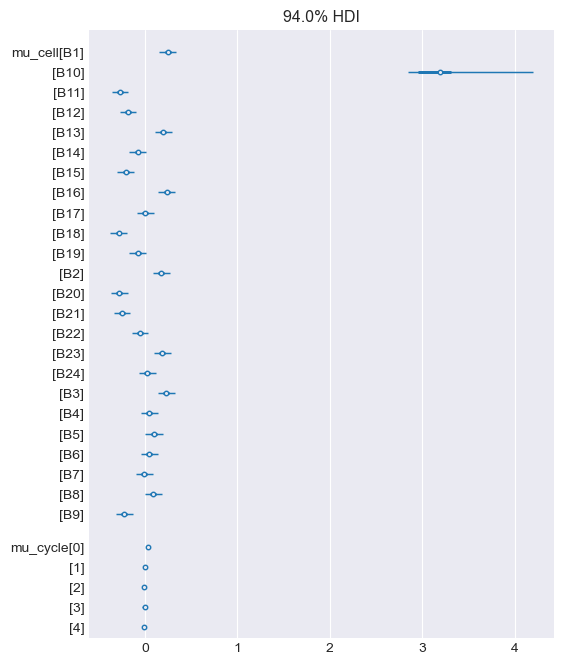

In [78]:
az.plot_forest(idata_multi, var_names=['mu_cell', 'mu_cycle'],
               combined=True, textsize=10);

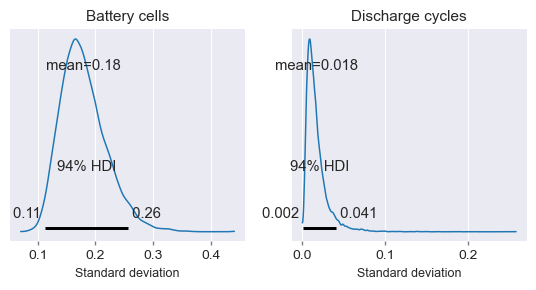

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(5.5, 3))
az.plot_posterior(idata_multi['posterior']['sigma_cells'],
                  textsize=10, ax=ax[0])
ax[0].set_title('Battery cells', fontsize=11)
ax[0].set_xlabel('Standard deviation', fontsize=9)
az.plot_posterior(idata_multi['posterior']['sigma_cycles'],
                  textsize=10, ax=ax[1])
ax[1].set_title('Discharge cycles', fontsize=11)
ax[1].set_xlabel('Standard deviation', fontsize=9)
fig.tight_layout()
plt.show()

In [ ]:
# Mean impedance for the battery cell B1 at first cycle.
cell_id = 0   # B1
cycle_id = 0  # first cycle
mu_base = idata_multi['posterior']['mu_base'].mean(dim=('chain', 'draw'))
mu_cell = idata_multi['posterior']['mu_cell'].mean(dim=('chain', 'draw'))[cell_id]
mu_cycle = idata_multi['posterior']['mu_cycle'].mean(dim=('chain', 'draw'))[cycle_id]
zi_mean = np.exp(mu_base.data + mu_cell.data + mu_cycle.data)  # original scale
print(zi_mean.round(3))

1.124


/home/ps/anaconda3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


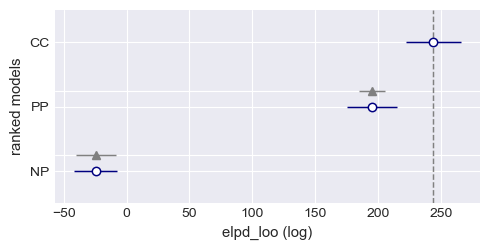

In [81]:
# Bayesian model comparison.
traces = {
    'PP': idata_cell,    # partial pooling (clustering on cells)
    'NP': idata_cycle2,  # partial pooling w/ unique var. (clustering on cycles)
    'CC': idata_multi,   # partial pooling w/ clustering on both cells and cycles
}
# Pareto-smoothed importance sampling leave-one-out cross-validation (LOOCV).
model_comparison = az.compare(traces, ic='loo', method='stacking')

fig, ax = plt.subplots(figsize=(5, 2.6))
az.plot_compare(model_comparison, plot_ic_diff=True, title=False, 
                textsize=10, plot_kwargs={'color_ic': 'navy'}, ax=ax)
fig.tight_layout()
plt.show()